In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from modules.cyclical_encoder import CyclicalEncoder
from modules.flight_preprocessor import FlightPreprocessor
from modules.smoothed_target_encoder import SmoothedTargetEncoder

In [2]:

RANDOM_STATE = 42
TEST_SIZE = 0.2

df_flights = pd.read_csv("./data/flights.csv", low_memory=False)
df_airports = pd.read_csv("./data/airports.csv", low_memory=False)

df_flights.columns = df_flights.columns.str.lower()
df_airports.columns = df_airports.columns.str.lower()
df_airports = df_airports[["iata_code", "state"]].copy()


# target (regressão): atraso na chegada
TARGET_COL = "arrival_delay"

processor = FlightPreprocessor()
df_flights = processor.preprocess(df_flights)

In [3]:
df_flights = (
    df_flights
    .merge(df_airports, how="left", left_on="origin_airport", right_on="iata_code")
    .rename(columns={"state": "state_origin"})
    .drop(columns=["iata_code"])
    .merge(df_airports, how="left", left_on="destination_airport", right_on="iata_code")
    .rename(columns={"state": "state_dest"})
    .drop(columns=["iata_code"])
)

base_features = [
    "airline",
    "origin_airport", "destination_airport",
    "state_origin", "state_dest",
    "distance",
    "scheduled_departure", "scheduled_arrival",
    "day_of_week", "month", "year",
]

df = df_flights[base_features + [TARGET_COL, "cancelled", "diverted"]].copy()

df = df[(df["cancelled"] == 0) & (df["diverted"] == 0)].copy()
df = df.dropna(subset=[TARGET_COL]).copy()

df[TARGET_COL] = df[TARGET_COL].clip(lower=0)

In [4]:
# ---------- Split primeiro (pra não vazar target no encoding) ----------
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

y_train = train_df[TARGET_COL].to_numpy()
y_test = test_df[TARGET_COL].to_numpy()

X_train = train_df.drop(columns=[TARGET_COL, "cancelled", "diverted"]).copy()
X_test  = test_df.drop(columns=[TARGET_COL, "cancelled", "diverted"]).copy()

In [5]:
# ---------- Time features + cyclical ----------
def add_time_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X["scheduled_departure"] = pd.to_datetime(X["scheduled_departure"], errors="coerce")
    X["scheduled_arrival"] = pd.to_datetime(X["scheduled_arrival"], errors="coerce")

    # departure
    X["dep_hour"] = X["scheduled_departure"].dt.hour + X["scheduled_departure"].dt.minute / 60
    X["dep_dayofyear"] = X["scheduled_departure"].dt.dayofyear

    # arrival
    X["arr_hour"] = X["scheduled_arrival"].dt.hour + X["scheduled_arrival"].dt.minute / 60
    X["arr_dayofyear"] = X["scheduled_arrival"].dt.dayofyear

    # remove datetimes brutos (evita colunas datetime no sklearn)
    X = X.drop(columns=["scheduled_departure", "scheduled_arrival"])
    return X

In [6]:
X_train = add_time_features(X_train)
X_test = add_time_features(X_test)

# cyclical encoding (fit no treino e aplica nos dois)
for col, period in [("dep_dayofyear", 365), ("dep_hour", 24), ("arr_dayofyear", 365), ("arr_hour", 24)]:
    enc = CyclicalEncoder(col, period=period)
    X_train = enc.fit_transform(X_train)
    X_test = enc.transform(X_test) if hasattr(enc, "transform") else enc.fit_transform(X_test)  # fallback


# ---------- Target encoding (fit no treino, transform no teste) ----------
cat_cols = ["origin_airport", "destination_airport", "airline", "state_origin", "state_dest"]

encoders = {
    "origin_airport": SmoothedTargetEncoder("origin_airport", TARGET_COL),
    "destination_airport": SmoothedTargetEncoder("destination_airport", TARGET_COL),
    "airline": SmoothedTargetEncoder("airline", TARGET_COL),
    "state_origin": SmoothedTargetEncoder("state_origin", TARGET_COL),
    "state_dest": SmoothedTargetEncoder("state_dest", TARGET_COL),
}


In [7]:
train_for_enc = pd.concat([X_train, train_df[[TARGET_COL]]], axis=1)
test_for_enc = pd.concat([X_test, test_df[[TARGET_COL]]], axis=1)  # target aqui só pra não quebrar interface, mas NÃO deve ser usado no fit

for col in cat_cols:
    if col not in X_train.columns:
        continue

    # fit no treino
    X_train[f"{col}_enc"] = encoders[col].fit_transform(train_for_enc)

    # transform no teste (ideal)
    if hasattr(encoders[col], "transform"):
        X_test[f"{col}_enc"] = encoders[col].transform(test_for_enc)
    else:
        # se sua classe não tem transform, recomendo MUITO adicionar.
        # fallback ruim: refaz fit_transform (vaza target) — evite.
        raise AttributeError(f"Seu SmoothedTargetEncoder não tem .transform() para a coluna {col}.")

# remove categóricas originais (agora que tem encoded)
X_train = X_train.drop(columns=[c for c in cat_cols if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in cat_cols if c in X_test.columns])

# garante que colunas batem
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

nan_train = X_train.isna().sum()
nan_train = nan_train[nan_train > 0].sort_values(ascending=False)

nan_test = X_test.isna().sum()
nan_test = nan_test[nan_test > 0].sort_values(ascending=False)

print("NaNs no treino:\n", nan_train.head(30))
print("\nNaNs no teste:\n", nan_test.head(30))

# % de linhas com pelo menos 1 NaN
pct_nan_rows_train = X_train.isna().any(axis=1).mean() * 100
pct_nan_rows_test = X_test.isna().any(axis=1).mean() * 100

print(f"% linhas com NaN (train): {pct_nan_rows_train:.2f}%")
print(f"% linhas com NaN (test):  {pct_nan_rows_test:.2f}%")

NaNs no treino:
 origin_airport_enc         984338
destination_airport_enc    984338
airline_enc                984338
state_origin_enc           984338
state_dest_enc             984338
dtype: int64

NaNs no teste:
 Series([], dtype: int64)
% linhas com NaN (train): 21.53%
% linhas com NaN (test):  0.00%


In [8]:
# alinhamento final
X_test = X_test.reindex(columns=X_train.columns)

num_cols = X_train.select_dtypes(include=[np.number]).columns
global_target_mean = y_train.mean()

# numéricos → mediana do treino
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].median())

# encoded → média global do target
enc_cols = [c for c in X_train.columns if c.endswith("_enc")]
X_train[enc_cols] = X_train[enc_cols].fillna(global_target_mean)
X_test[enc_cols] = X_test[enc_cols].fillna(global_target_mean)

# sanity check
assert not X_train.isna().any().any()
assert not X_test.isna().any().any()

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# ---------- Model ----------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train_log)

y_pred_log = lin_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)  # opcional: não prever atraso negativo

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("### Model Evaluation Results (Test Set) ###")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.4f}")

### Model Evaluation Results (Test Set) ###
MAE:  12.54
RMSE: 37.01
R2:   -0.0780


In [9]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.5,
    max_iter=5000,
    random_state=42
)

model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")


MAE: 12.56
RMSE: 37.05
R2: -0.0803


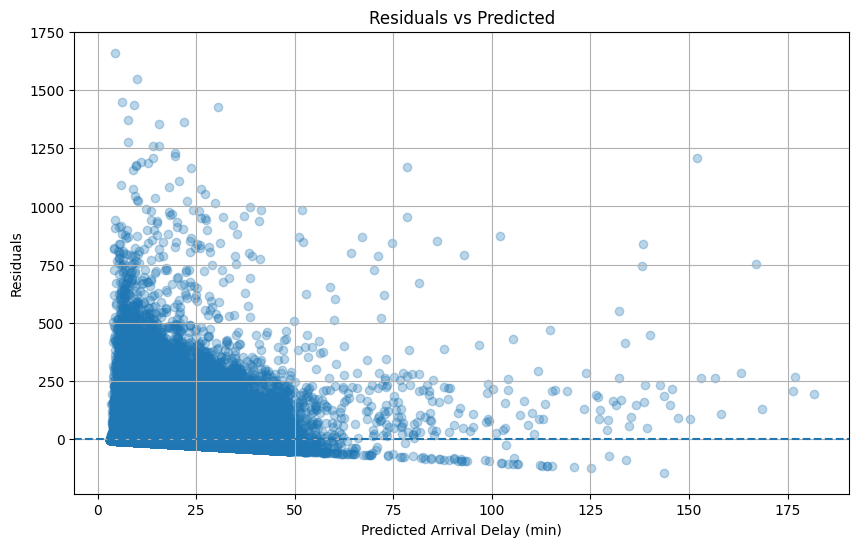

In [11]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Arrival Delay (min)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

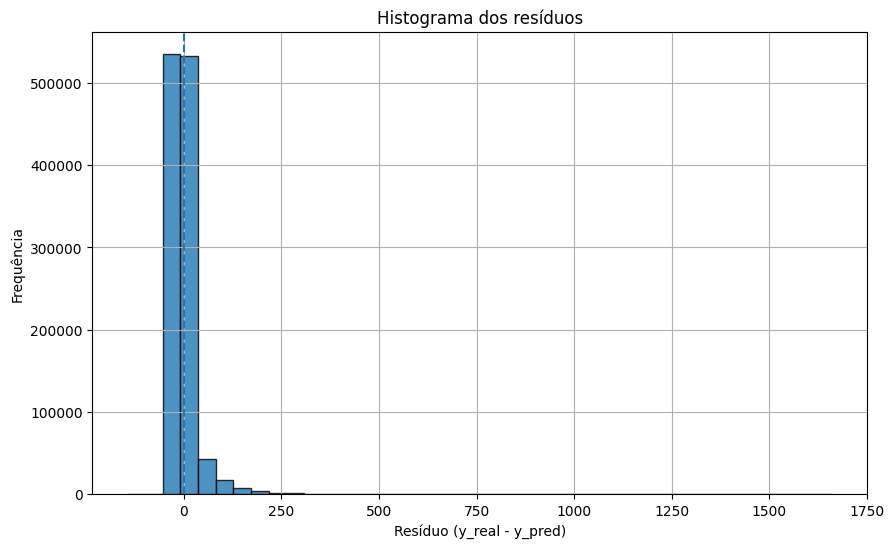

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=40, edgecolor="black", alpha=0.8)
plt.axvline(0, linestyle="--")
plt.xlabel("Resíduo (y_real - y_pred)")
plt.ylabel("Frequência")
plt.title("Histograma dos resíduos")
plt.grid(True)
plt.show()


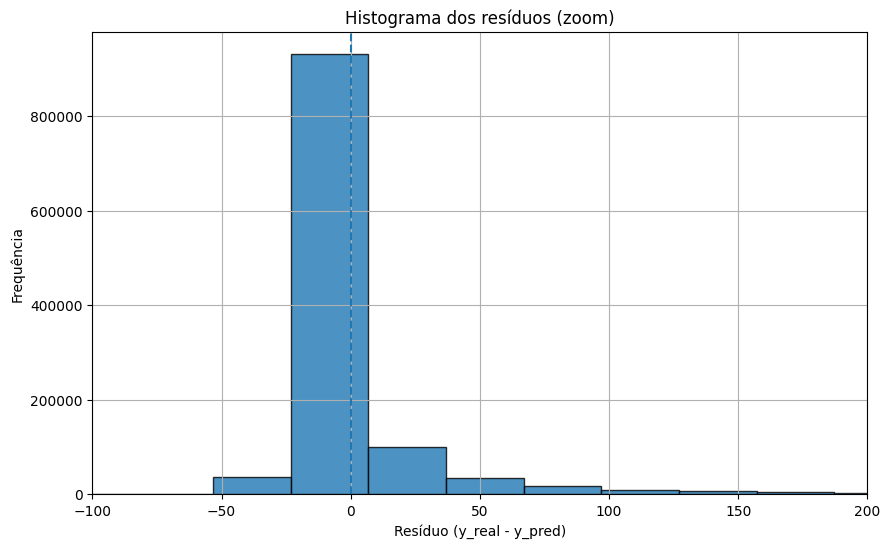

In [13]:
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=60, edgecolor="black", alpha=0.8)
plt.axvline(0, linestyle="--")
plt.xlim(-100, 200)  # zoom onde está a maioria
plt.title("Histograma dos resíduos (zoom)")
plt.xlabel("Resíduo (y_real - y_pred)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


In [14]:
pd.Series(residuals).describe()

count    1.142802e+06
mean    -1.822079e-01
std      3.475300e+01
min     -1.435412e+02
25%     -1.184342e+01
50%     -7.849136e+00
75%     -3.921761e+00
max      1.660492e+03
dtype: float64

In [15]:
df_eval = pd.DataFrame({
    "y_real": y_test,
    "y_pred": y_pred
})

df_eval["abs_error"] = np.abs(df_eval["y_real"] - df_eval["y_pred"])

In [16]:
bins = [-np.inf, 0, 15, 60, np.inf]
labels = [
    "Antecipado / No horário",
    "Atraso leve (0–15)",
    "Atraso médio (15–60)",
    "Atraso severo (>60)"
]

df_eval["delay_band"] = pd.cut(
    df_eval["y_real"],
    bins=bins,
    labels=labels
)

In [17]:
mae_by_band = (
    df_eval
    .groupby("delay_band")
    .agg(
        MAE=("abs_error", "mean"),
        Qtd_Voos=("abs_error", "count")
    )
    .reset_index()
)

mae_by_band


C:\Users\User\AppData\Local\Temp\ipykernel_6524\1985304424.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("delay_band")


,delay_band,MAE,Qtd_Voos
0,Antecipado / No horário,11.157928,725638
1,Atraso leve (0–15),7.304238,212370
2,Atraso médio (15–60),17.471806,141149
3,Atraso severo (>60),107.803681,63645


In [18]:
def plot_y_true_vs_y_pred(y_true, y_pred, title="Real vs Previsto"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())

    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.xlabel("Valor real")
    plt.ylabel("Valor previsto")
    plt.title(title)
    plt.grid(True)
    plt.show()

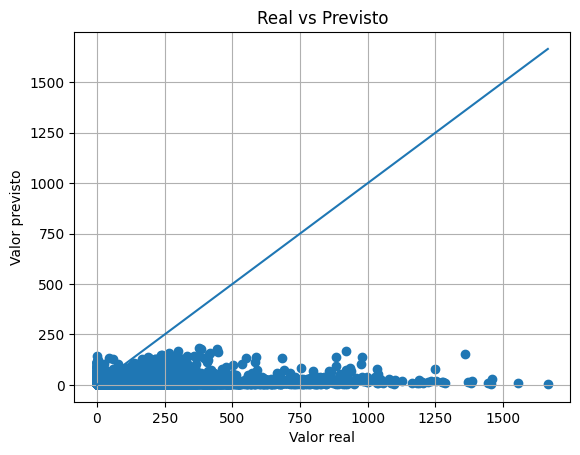

In [19]:
plot_y_true_vs_y_pred(y_test, y_pred)

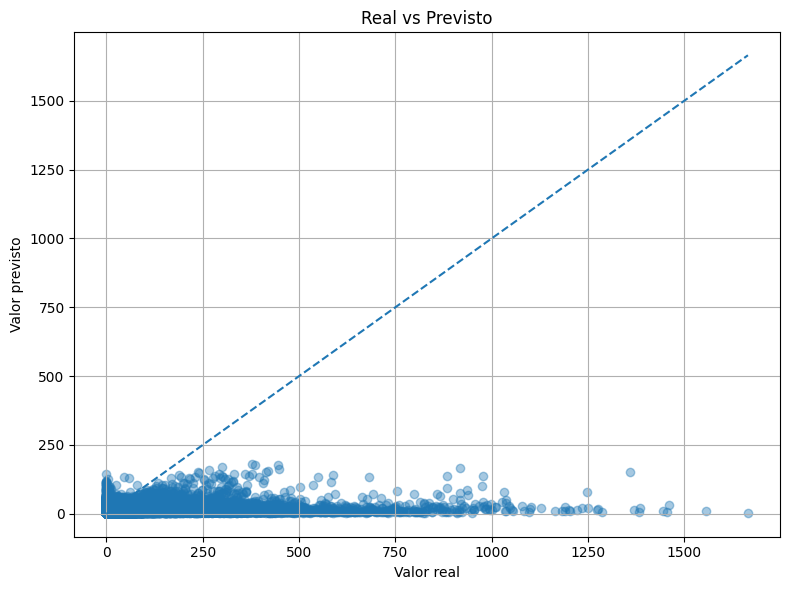

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.4)

# linha y = x
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("Real vs Previsto")

plt.grid(True)
plt.tight_layout()
plt.show()


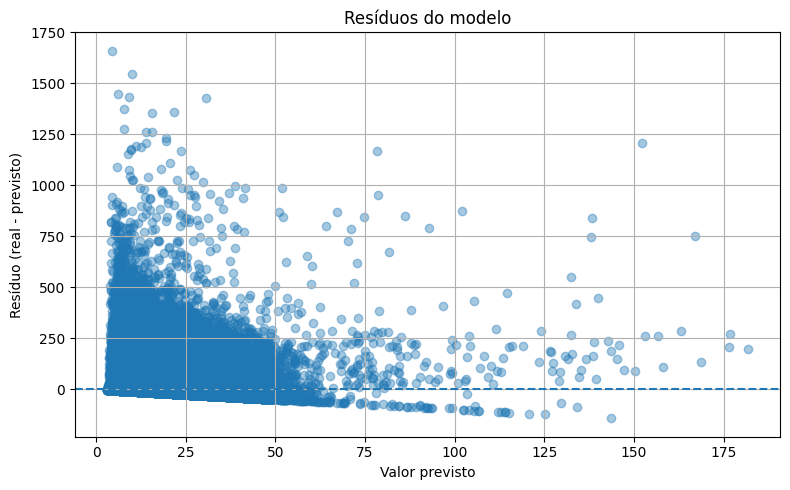

In [21]:
residuos = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.4)
plt.axhline(0, linestyle='--')

plt.xlabel("Valor previsto")
plt.ylabel("Resíduo (real - previsto)")
plt.title("Resíduos do modelo")

plt.grid(True)
plt.tight_layout()
plt.show()


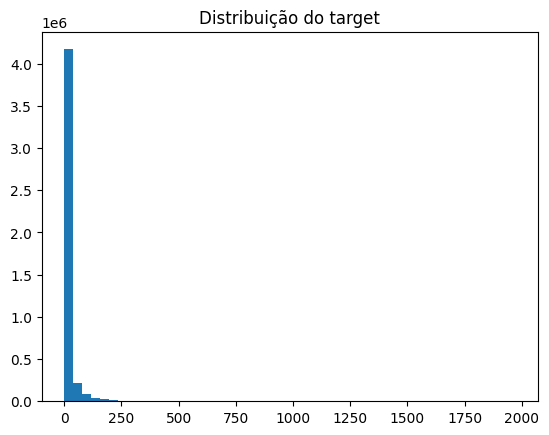

In [22]:
plt.hist(y_train, bins=50)
plt.title("Distribuição do target")
plt.show()


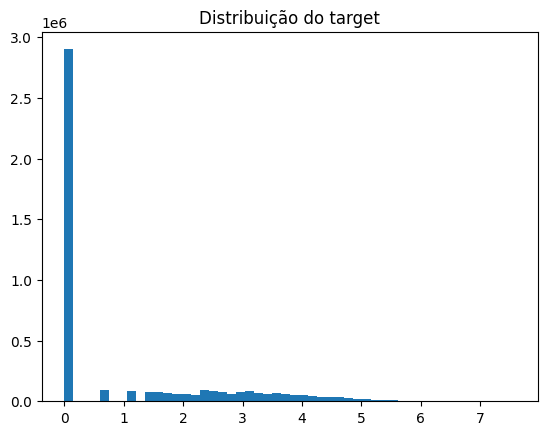

In [23]:
plt.hist(y_train_log, bins=50)
plt.title("Distribuição do target")
plt.show()

c:\Users\User\OneDrive\Documents\Git Workspace\fiap-machine-learning-tech-challenge-3\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Random Forest Evaluation Results (Test Set) ###
MAE:  12.42
RMSE: 36.82
R2:   -0.0671


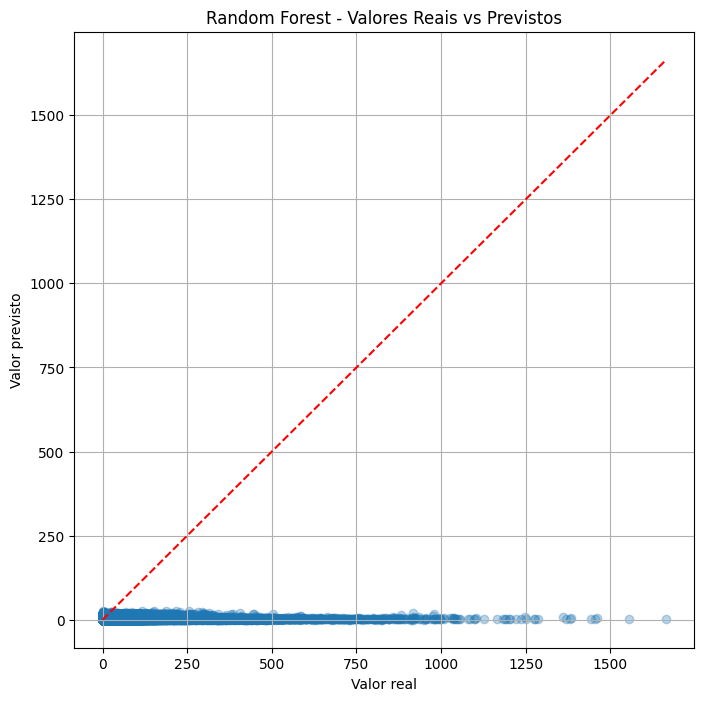

In [26]:
# ===============================
# Modelo - Random Forest Regressor
# ===============================
rf = RandomForestRegressor(
    n_estimators=100,        # ↓ fewer trees
    max_depth=10,            # ↓ shallow trees
    min_samples_leaf=30,     # ↓ limits splits
    max_features="sqrt",     # ↓ fewer features per split
    n_jobs=-1,
    random_state=42
)

# =========================
# Treino
# =========================
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rf.fit(X_train, y_train_log)
y_pred = np.expm1(rf.predict(X_test))

# =========================
# Métricas
# =========================
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("### Random Forest Evaluation Results (Test Set) ###")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.4f}")

# =========================
# Gráfico y_true vs y_pred
# =========================
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("Random Forest - Valores Reais vs Previstos")
plt.grid(True)
plt.show()
